In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import ruamel.yaml as yaml
from torch.optim import Adam
from torch.utils.data import DataLoader
import subprocess
from functools import partial
import sys

import sys
sys.path.append("../studiogan")

from soul_gan.utils.train.trainer import Trainer
from soul_gan.utils.train.loss import LossRegistry
from soul_gan.utils.general_utils import DotConfig, CONFIGS_DIR, ROOT_DIR
from soul_gan.models.utils import GANWrapper
from soul_gan.sample import soul
from soul_gan.feature import FeatureRegistry
from soul_gan.distribution import DistributionRegistry
from soul_gan.utils.callbacks import CallbackRegistry
from soul_gan.datasets.utils import get_dataset
from soul_gan.utils.eval_feature import evaluate

2022-04-02 13:04:05.161522: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
from easydict import EasyDict as edict

args = edict()

configs = ['configs/exp_configs/mlp-cmd.yml', 'configs/targets/discriminator.yml', 'configs/gan_configs/ring-mlp.yml', 'configs/feature_configs/cmd_2d.yml', 'configs/train_2d.yml']
configs = [Path(ROOT_DIR, x).as_posix() for x in configs]
args.configs = configs

In [3]:
params = yaml.round_trip_load(Path(args.configs[0]).open("r"))

In [4]:
proc = subprocess.Popen("/bin/bash", stdin=subprocess.PIPE, stdout=subprocess.PIPE)
out, err = proc.communicate(
    (
        " ".join(
            [
                "echo",
                '"' + str(yaml.round_trip_dump(params)) + '"',
                "|",
                "cat - ",
                *args.configs[1:],
            ]
        )
    ).encode("utf-8")
)
config = yaml.round_trip_load(out.decode("utf-8"))
config = DotConfig(config)

In [5]:
gan = GANWrapper(config.gan_config, device=config.device, load_weights=False)

In [6]:
train_config = config.train_params
criterion_g = LossRegistry.create(train_config.criterion_g.name)
criterion_d = LossRegistry.create(train_config.criterion_d.name)

optimizer_g = eval(train_config.optimizer_g.name)(gan.gen.parameters(), lr=train_config.optimizer_g.params.lr, betas=train_config.optimizer_g.params.betas)
optimizer_d = eval(train_config.optimizer_d.name)(gan.dis.parameters(), lr=train_config.optimizer_d.params.lr, betas=train_config.optimizer_d.params.betas)


In [7]:
dataset_dict = get_dataset("gaussians_ring", mean=config.gan_config.train_transform.Normalize.mean, std=config.gan_config.train_transform.Normalize.std)
dataset = dataset_dict["dataset"]
dataloader = DataLoader(dataset, batch_size=config.batch_size)

In [8]:
train_callbacks = []
for callback_name, callback in config.callbacks.train_callbacks.items():
    train_callbacks.append(CallbackRegistry.create(callback.name, **callback.params))

In [9]:
feature_callbacks = []
callbacks = config.callbacks.feature_callbacks
if callbacks:
    for _, callback in callbacks.items():
        params = callback.params.dict
        # HACK
        if "gan" in params:
            params["gan"] = gan
        # if "save_dir" in params:
        #     params["save_dir"] = save_dir
        # if "np_dataset" in params:
        #     np_dataset = np.concatenate([gan.inverse_transform(batch).numpy() for batch in dataloader], 0)
        #     params["np_dataset"] = np_dataset
        feature_callbacks.append(
            CallbackRegistry.create(callback.name, **params)
        )

feature_kwargs = config.feature.params.dict
feature_kwargs["ref_stats_path"] = Path(ROOT_DIR, feature_kwargs["ref_stats_path"]).as_posix()

# HACK
if "gan" in config.sample_params.feature.params:
    feature_kwargs["gan"] = gan
if "dataloader" in config.sample_params.feature.params:
    feature_kwargs["dataloader"] = dataloader

feature = FeatureRegistry.create(
    config.feature.name,
    callbacks=feature_callbacks,
    inverse_transform=gan.inverse_transform,
    **feature_kwargs,
)

if config.sample_params.feature.params.ref_stats_path:
    feature.eval = True
    stats = evaluate(
        feature,
        dataset,
        config.batch_size,
        config.device,
        Path(ROOT_DIR, config.sample_params.feature.params.ref_stats_path),
    )
    print(stats)
    feature = FeatureRegistry.create(
        config.sample_params.feature.name,
        callbacks=feature_callbacks,
        inverse_transform=gan.inverse_transform,
        **feature_kwargs,
    )
feature.eval = False

100%|██████████| 5/5 [00:00<00:00, 239.67it/s]

defaultdict(<function evaluate.<locals>.<lambda> at 0x7ff35b2b6af0>, {0: array([ 9.5625874e-06,  4.1923951e-05,  1.1813395e-01,  1.1703535e-01,
       -7.3284609e-06,  2.8375909e-05], dtype=float32)})


In [10]:
ref_dist = DistributionRegistry.create(config.sample_params.distribution.name, gan=gan) #, **sample_params.distribution.params)
sample_fn = partial(soul, gen=gan.gen, ref_dist=ref_dist, feature=feature, **config.sample_params.params)

In [11]:
trainer = Trainer(
    gan, 
    optimizer_g, 
    optimizer_d, 
    criterion_g, 
    criterion_d, 
    dataloader, 
    device=config.device, 
    n_dis=train_config.n_dis, 
    callbacks=train_callbacks,
    sample_fn=sample_fn
    )

In [12]:
trainer.train(n_epochs=train_config.n_epochs)

Epoch: 0, Loss G: 0.6561220407485963, Loss D: 6.244720816612244
Epoch: 10, Loss G: 2.4347618103027346, Loss D: 0.9954729080200195
Epoch: 20, Loss G: 2.2835834980010987, Loss D: 2.1753192245960236
Epoch: 30, Loss G: 2.1646979331970213, Loss D: 1.9758872091770172
Epoch: 40, Loss G: 2.237870216369629, Loss D: 1.8448194861412048
Epoch: 50, Loss G: 2.260161781311035, Loss D: 1.741582065820694


KeyboardInterrupt: 

In [13]:
z = gan.gen.prior.sample((1000, ))
x = gan.gen(z).detach().cpu().numpy()

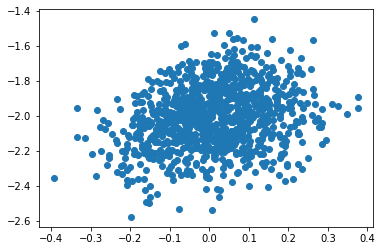

In [14]:
from matplotlib import pyplot as plt

plt.scatter(x[:, 0], x[:, 1])